In [3]:
import torch
if torch.cuda.is_available():
    print("GPU is available!")
    print(f"GPU name: {torch.cuda.get_device_name(0)}")
else:
    print("GPU not available, using CPU.")

GPU is available!
GPU name: NVIDIA GeForce RTX 3060 Ti


In [4]:
# Create a list of all the class names
import os
IMAGE_DIR = "data\\Mosquito-on-human-skin\\data_splitting"
class_names = sorted(os.listdir(IMAGE_DIR+"/Pred"))
class_names

['Culex landing',
 'Culex smashed',
 'aegypti landing',
 'aegypti smashed',
 'albopictus landing',
 'albopictus smashed']

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils
from torch.utils.data import random_split
import torch.utils.data
from collections import defaultdict
from PIL import Image
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [6]:
# Data preprocessing for ResNet-50 (requires 224x224 input)
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])

transform_test = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
# Create datasets and data loaders
trainset = datasets.ImageFolder(root="data/Mosquito-on-human-skin/data_splitting/Train", transform=transform_train)

# Split training set into train and validation
train_size = int(len(trainset) * 0.8)
val_size = len(trainset) - train_size
train_subset, val_subset = random_split(trainset, [train_size, val_size])

# Create data loaders
trainloader = torch.utils.data.DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
valloader = torch.utils.data.DataLoader(val_subset, batch_size=32, shuffle=False, num_workers=2, pin_memory=True)

# Test dataset
testset = datasets.ImageFolder(root="data/Mosquito-on-human-skin/data_splitting/Test", transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False)

print(f"Training samples: {len(train_subset)}")
print(f"Validation samples: {len(val_subset)}")
print(f"Test samples: {len(testset)}")
print(f"Number of classes: {len(class_names)}")

Training samples: 3360
Validation samples: 840
Test samples: 1799
Number of classes: 6


In [8]:
# ResNet-50 Implementation
class BasicBlock(nn.Module):
    expansion = 1
    
    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class Bottleneck(nn.Module):
    expansion = 4
    
    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion * planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion * planes)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=6):
        super(ResNet, self).__init__()
        self.in_planes = 64
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)
        self.dropout = nn.Dropout(p=0.5)
    
    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.maxpool(out)
        
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.dropout(out)
        out = self.fc(out)
        return out

def ResNet50(num_classes=6):
    return ResNet(Bottleneck, [3, 4, 6, 3], num_classes)

In [9]:
# Initialize device and model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Create ResNet-50 model
model = ResNet50(num_classes=len(class_names)).to(device)

# Test the model
test_input = torch.randn(1, 3, 224, 224).to(device)
test_output = model(test_input)
print(f"Model output shape: {test_output.shape}")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)

Using device: cuda
Model output shape: torch.Size([1, 6])
Number of parameters: 23,520,326
Model output shape: torch.Size([1, 6])
Number of parameters: 23,520,326


In [10]:
# Training and evaluation functions
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

def train_model(model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    best_val_acc = 0.0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels) in enumerate(trainloader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            if batch_idx % 20 == 0:
                print(f'Epoch {epoch+1}/{num_epochs}, Batch {batch_idx}/{len(trainloader)}, '
                      f'Loss: {loss.item():.4f}')
        
        train_loss = running_loss / len(trainloader)
        train_acc = 100 * correct / total
        
        # Validation phase
        val_loss, val_acc = evaluate(model, valloader, criterion, device)
        
        # Update learning rate
        scheduler.step()
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print(f'  Learning Rate: {scheduler.get_last_lr()[0]:.6f}')
        print('-' * 50)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_resnet50_mosquito.pth')
            print(f'New best model saved with validation accuracy: {val_acc:.2f}%')
    
    return train_losses, val_losses, train_accuracies, val_accuracies

In [11]:
# Train the model
num_epochs = 30
print("Starting ResNet-50 training...")
print(f"Training for {num_epochs} epochs")
print(f"Class names: {class_names}")
print("=" * 60)

train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    model, trainloader, valloader, criterion, optimizer, scheduler, num_epochs, device
)

Starting ResNet-50 training...
Training for 30 epochs
Class names: ['Culex landing', 'Culex smashed', 'aegypti landing', 'aegypti smashed', 'albopictus landing', 'albopictus smashed']
Epoch 1/30, Batch 0/105, Loss: 2.1678
Epoch 1/30, Batch 0/105, Loss: 2.1678
Epoch 1/30, Batch 20/105, Loss: 1.7374
Epoch 1/30, Batch 20/105, Loss: 1.7374
Epoch 1/30, Batch 40/105, Loss: 1.7938
Epoch 1/30, Batch 40/105, Loss: 1.7938
Epoch 1/30, Batch 60/105, Loss: 1.9506
Epoch 1/30, Batch 60/105, Loss: 1.9506
Epoch 1/30, Batch 80/105, Loss: 1.7442
Epoch 1/30, Batch 80/105, Loss: 1.7442
Epoch 1/30, Batch 100/105, Loss: 1.3289
Epoch 1/30, Batch 100/105, Loss: 1.3289
Epoch 1/30:
  Train Loss: 1.7843, Train Acc: 28.45%
  Val Loss: 3.1366, Val Acc: 20.12%
  Learning Rate: 0.001000
--------------------------------------------------
New best model saved with validation accuracy: 20.12%
Epoch 1/30:
  Train Loss: 1.7843, Train Acc: 28.45%
  Val Loss: 3.1366, Val Acc: 20.12%
  Learning Rate: 0.001000
---------------

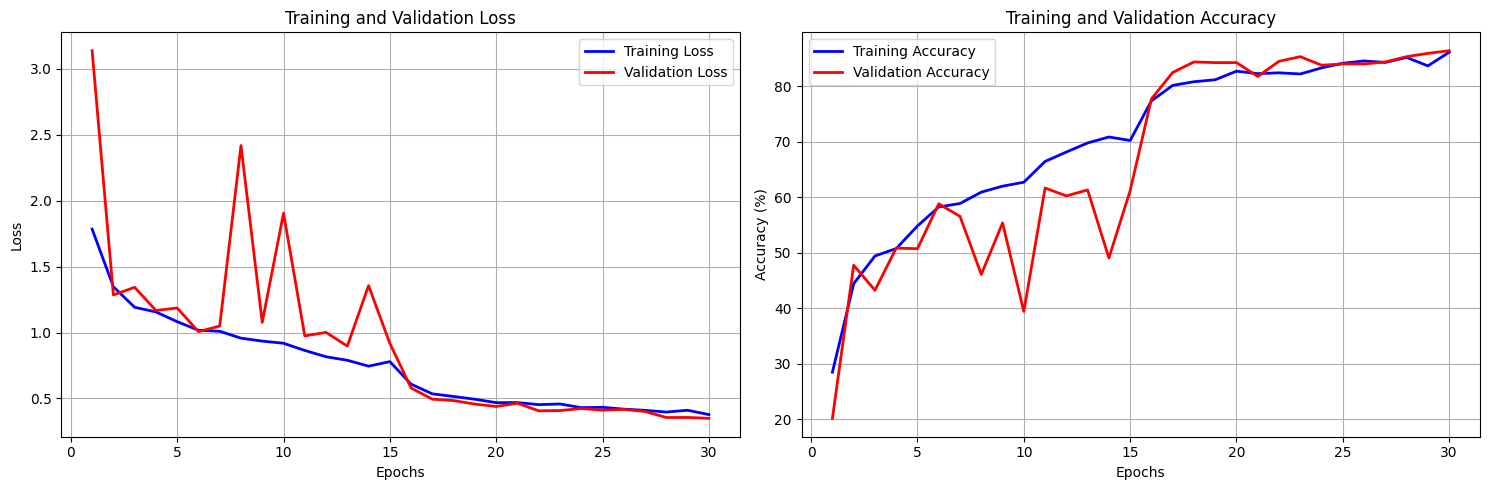

In [12]:
# Plot training curves
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot losses
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss', linewidth=2)
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy', linewidth=2)
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy', linewidth=2)
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies)

In [13]:
# Comprehensive testing function
def test_model(model, testloader, criterion, device, class_names):
    model.eval()
    correct = 0
    total = 0
    class_correct = defaultdict(int)
    class_total = defaultdict(int)
    
    all_preds = []
    all_labels = []
    correct_images = {}
    
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Store predictions for confusion matrix
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
            # Per-class accuracy
            for img, label, pred in zip(images, labels, predicted):
                class_total[label.item()] += 1
                if label == pred:
                    class_correct[label.item()] += 1
                    # Store first correct prediction for each class
                    if label.item() not in correct_images:
                        correct_images[label.item()] = (img.cpu(), class_names[label.item()])
    
    # Overall accuracy
    overall_accuracy = 100 * correct / total
    print(f'Test Accuracy: {overall_accuracy:.2f}%')
    print()
    
    # Per-class accuracy
    print('Per-class Accuracy:')
    for i in range(len(class_names)):
        if class_total[i] > 0:
            class_acc = 100 * class_correct[i] / class_total[i]
            print(f'{class_names[i]}: {class_acc:.2f}% ({class_correct[i]}/{class_total[i]})')
        else:
            print(f'{class_names[i]}: No samples')
    
    return correct_images, all_labels, all_preds, overall_accuracy

# Test the model
correct_images, all_labels, all_preds, test_accuracy = test_model(model, testloader, criterion, device, class_names)

Test Accuracy: 89.22%

Per-class Accuracy:
Culex landing: 95.33% (286/300)
Culex smashed: 98.67% (296/300)
aegypti landing: 83.33% (250/300)
aegypti smashed: 86.00% (258/300)
albopictus landing: 89.97% (269/299)
albopictus smashed: 82.00% (246/300)


\n============================================================
RESNET-50 RESULTS


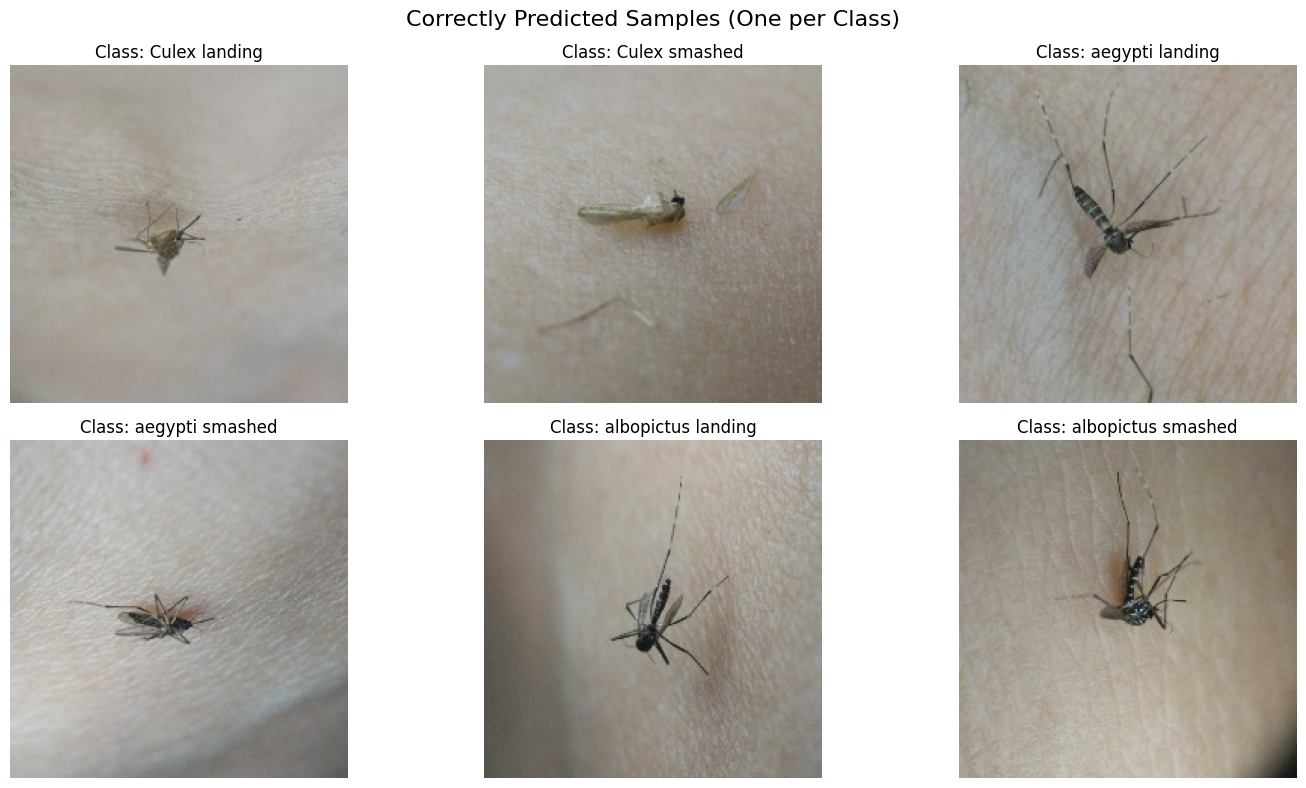

In [14]:
# Visualization functions
def plot_correct_predictions(correct_images, class_names):
    """Plot correctly predicted images for each class"""
    plt.figure(figsize=(15, 8))
    
    for i, (label_idx, (img, label_name)) in enumerate(correct_images.items()):
        plt.subplot(2, 3, i + 1)
        
        # Denormalize the image for display
        img_denorm = img.clone()
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        for t, m, s in zip(img_denorm, mean, std):
            t.mul_(s).add_(m)
        img_denorm = torch.clamp(img_denorm, 0, 1)
        
        # Convert to numpy and transpose for matplotlib
        img_np = img_denorm.permute(1, 2, 0).numpy()
        
        plt.imshow(img_np)
        plt.title(f'Class: {label_name}', fontsize=12)
        plt.axis('off')
    
    plt.suptitle('Correctly Predicted Samples (One per Class)', fontsize=16)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(all_labels, all_preds, class_names):
    """Plot confusion matrix"""
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    
    plt.figure(figsize=(10, 8))
    disp.plot(cmap="Blues", values_format="d")
    plt.title("Confusion Matrix - ResNet-50", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Display results
print("\\n" + "="*60)
print("RESNET-50 RESULTS")
print("="*60)

plot_correct_predictions(correct_images, class_names)

<Figure size 1000x800 with 0 Axes>

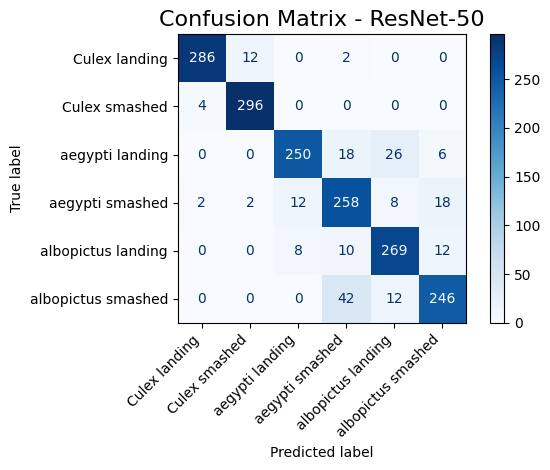

\n============================================================
MODEL SUMMARY AND COMPARISON
ResNet-50 Test Accuracy: 89.22%
Number of parameters: 23,520,326
Model size: 89.7 MB
\nKey Features of ResNet-50:
- 50 layers deep with residual connections
- Batch normalization and skip connections
- Pre-trained ImageNet weights could be used for transfer learning
- Input size: 224x224 (higher resolution than simple CNN)
- Advanced data augmentation and learning rate scheduling
\nFinal model saved as 'final_resnet50_mosquito.pth'


In [15]:
# Display confusion matrix
plot_confusion_matrix(all_labels, all_preds, class_names)

# Model summary and comparison
print("\\n" + "="*60)
print("MODEL SUMMARY AND COMPARISON")
print("="*60)
print(f"ResNet-50 Test Accuracy: {test_accuracy:.2f}%")
print(f"Number of parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Model size: {sum(p.numel() * 4 for p in model.parameters()) / (1024**2):.1f} MB")
print("\\nKey Features of ResNet-50:")
print("- 50 layers deep with residual connections")
print("- Batch normalization and skip connections")
print("- Pre-trained ImageNet weights could be used for transfer learning")
print("- Input size: 224x224 (higher resolution than simple CNN)")
print("- Advanced data augmentation and learning rate scheduling")

# Save the final model
torch.save(model.state_dict(), 'final_resnet50_mosquito.pth')
print("\\nFinal model saved as 'final_resnet50_mosquito.pth'")